In [497]:
import os
import random
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
plt.style.use("ggplot")
from PIL import Image

In [498]:
from tqdm import tqdm_notebook, tnrange
from itertools import chain
from skimage.io import imread, imshow, concatenate_images
from skimage.transform import resize
from skimage.morphology import label
from sklearn.model_selection import train_test_split

In [499]:
import tensorflow as tf

In [500]:
from keras.models import Model, load_model
from keras.layers import Input, BatchNormalization, Activation, Dense, Dropout
from keras.layers.core import Lambda, RepeatVector, Reshape
from keras.layers.convolutional import Conv2D, Conv2DTranspose

In [501]:
from keras.layers.pooling import MaxPooling2D, GlobalMaxPool2D
from keras.layers.merge import concatenate, add
from keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from keras.optimizers import Adam
from keras.preprocessing.image import ImageDataGenerator, array_to_img, img_to_array, load_img

In [502]:
p=os.getcwd()

In [503]:
print(p)

/home/ipsa


In [504]:
im_width = 128
im_height = 128
border = 5

In [505]:
path_train = '/home/ipsa/Downloads/TMAP/train/'
path_test = '/home/ipsa/Downloads/TMAP/test/'

In [510]:
def get_data(path, train=True):
    ids = next(os.walk(path + "images"))[2]
    print(ids)
    X = np.zeros((len(ids), im_height, im_width, 1), dtype=np.float32)
    if train:
        y = np.zeros((len(ids), im_height, im_width, 1), dtype=np.float32)
    print('Getting and resizing images ... ')
    for n, id_ in tqdm_notebook(enumerate(ids), total=len(ids)):
        # Load images
        img = load_img(path + '/images/' + id_, grayscale=True)
        x_img = img_to_array(img)
        #plt.imshow(x_img/255.)
        x_img = resize(x_img, (128, 128, 1), mode='constant', preserve_range=True)
        #plt.imshow(x_img/255.)
        # Load masks
        if train:
            mask = img_to_array(load_img(path + '/masks/' + id_, grayscale=True))
            mask = resize(mask, (128, 128, 1), mode='constant', preserve_range=True)

        # Save images
        
        X[n, ..., 0] = x_img.squeeze() / 255
        if train:
            y[n] = mask / 255
    print('Done!')
    if train:
        return X, y
    else:
        return X

In [511]:
X, y = get_data(path_train, train=True)

['r4.jpg', 'r26.jpg', 'r7.jpg', 'r27.jpg', 'r17.jpg', 'r23.jpg', 'r8.jpg', 'r10.jpg', 'r25.jpg', 'r14.jpg', 'r19.jpg', 'r9.jpg', 'r6.jpg', 'r33.jpg', 'r22.jpg', 'r12.jpg', 'r2.jpg', 'r30.jpg', 'r18.jpg', 'r5.jpg', 'r31.jpg', 'r11.jpg', 'r16.jpg', 'r21.jpg', 'r20.jpg', 'r34.jpg', 'r29.jpg', 'r1.jpg', 'r3.jpg', 'r32.jpg', 'r15.jpg', 'r28.jpg', 'r24.jpg']
Getting and resizing images ... 


/home/ipsa/m1/lib/python3.5/site-packages/keras_preprocessing/image.py:492: UserWarning: grayscale is deprecated. Please use color_mode = "grayscale"
  warnings.warn('grayscale is deprecated. Please use '



Done!


In [514]:
X[0].shape

(128, 128, 1)

In [516]:
X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.3, random_state=2668)

In [517]:
ix = random.randint(0, len(X_train))

In [518]:
has_mask = y_train[ix].max() > 0

In [525]:
def conv2d_block(input_tensor, n_filters, kernel_size=3, batchnorm=True):
    # first layer
    x = Conv2D(filters=n_filters, kernel_size=(kernel_size, kernel_size), kernel_initializer="he_normal",
               padding="same")(input_tensor)
    if batchnorm:
        x = BatchNormalization()(x)
    x = Activation("relu")(x)
    # second layer
    x = Conv2D(filters=n_filters, kernel_size=(kernel_size, kernel_size), kernel_initializer="he_normal",
               padding="same")(x)
    if batchnorm:
        x = BatchNormalization()(x)
    x = Activation("relu")(x)
    return x

In [526]:
def get_unet(input_img, n_filters=16, dropout=0.5, batchnorm=True):
    # contracting path
    c1 = conv2d_block(input_img, n_filters=n_filters*1, kernel_size=3, batchnorm=batchnorm)
    p1 = MaxPooling2D((2, 2)) (c1)
    p1 = Dropout(dropout*0.5)(p1)

    c2 = conv2d_block(p1, n_filters=n_filters*2, kernel_size=3, batchnorm=batchnorm)
    p2 = MaxPooling2D((2, 2)) (c2)
    p2 = Dropout(dropout)(p2)

    c3 = conv2d_block(p2, n_filters=n_filters*4, kernel_size=3, batchnorm=batchnorm)
    p3 = MaxPooling2D((2, 2)) (c3)
    p3 = Dropout(dropout)(p3)

    c4 = conv2d_block(p3, n_filters=n_filters*8, kernel_size=3, batchnorm=batchnorm)
    p4 = MaxPooling2D(pool_size=(2, 2)) (c4)
    p4 = Dropout(dropout)(p4)
    
    c5 = conv2d_block(p4, n_filters=n_filters*16, kernel_size=3, batchnorm=batchnorm)
    
    # expansive path
    u6 = Conv2DTranspose(n_filters*8, (3, 3), strides=(2, 2), padding='same') (c5)
    u6 = concatenate([u6, c4])
    u6 = Dropout(dropout)(u6)
    c6 = conv2d_block(u6, n_filters=n_filters*8, kernel_size=3, batchnorm=batchnorm)

    u7 = Conv2DTranspose(n_filters*4, (3, 3), strides=(2, 2), padding='same') (c6)
    u7 = concatenate([u7, c3])
    u7 = Dropout(dropout)(u7)
    c7 = conv2d_block(u7, n_filters=n_filters*4, kernel_size=3, batchnorm=batchnorm)

    u8 = Conv2DTranspose(n_filters*2, (3, 3), strides=(2, 2), padding='same') (c7)
    u8 = concatenate([u8, c2])
    u8 = Dropout(dropout)(u8)
    c8 = conv2d_block(u8, n_filters=n_filters*2, kernel_size=3, batchnorm=batchnorm)

    u9 = Conv2DTranspose(n_filters*1, (3, 3), strides=(2, 2), padding='same') (c8)
    u9 = concatenate([u9, c1], axis=3)
    u9 = Dropout(dropout)(u9)
    c9 = conv2d_block(u9, n_filters=n_filters*1, kernel_size=3, batchnorm=batchnorm)
    
    outputs = Conv2D(1, (1, 1), activation='sigmoid') (c9)
    model = Model(inputs=[input_img], outputs=[outputs])
    return model

In [527]:
input_img = Input((im_height, im_width, 1), name='img')
model = get_unet(input_img, n_filters=16, dropout=0.18, batchnorm=True)


In [528]:
model.compile(optimizer=Adam(), loss="binary_crossentropy", metrics=["accuracy"])

In [529]:
model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
img (InputLayer)                (None, 128, 128, 1)  0                                            
__________________________________________________________________________________________________
conv2d_229 (Conv2D)             (None, 128, 128, 16) 160         img[0][0]                        
__________________________________________________________________________________________________
batch_normalization_217 (BatchN (None, 128, 128, 16) 64          conv2d_229[0][0]                 
__________________________________________________________________________________________________
activation_217 (Activation)     (None, 128, 128, 16) 0           batch_normalization_217[0][0]    
__________________________________________________________________________________________________
conv2d_230

In [530]:
callbacks = [
    EarlyStopping(patience=10, verbose=1),
    ReduceLROnPlateau(factor=0.1, patience=3, min_lr=0.1, verbose=1),
    ModelCheckpoint('model-weights.h5', verbose=1, save_best_only=True, save_weights_only=True)
]

In [533]:
results = model.fit(X_train, y_train, batch_size=9, epochs=10, callbacks=callbacks,
                    validation_data=(X_valid, y_valid))

Train on 29 samples, validate on 4 samples
Epoch 1/10
29/29 [==============================] - 5s 177ms/step - loss: 0.3505 - acc: 0.8482 - val_loss: 3.4617 - val_acc: 0.4682

Epoch 00001: val_loss did not improve from 0.76923
Epoch 2/10
29/29 [==============================] - 1s 51ms/step - loss: 0.3611 - acc: 0.8343 - val_loss: 3.7065 - val_acc: 0.4588

Epoch 00002: val_loss did not improve from 0.76923
Epoch 3/10
29/29 [==============================] - 1s 50ms/step - loss: 0.3516 - acc: 0.8436 - val_loss: 3.0688 - val_acc: 0.5027

Epoch 00003: val_loss did not improve from 0.76923
Epoch 4/10
29/29 [==============================] - 1s 50ms/step - loss: 0.3410 - acc: 0.8453 - val_loss: 1.3687 - val_acc: 0.6654

Epoch 00004: val_loss did not improve from 0.76923
Epoch 5/10
29/29 [==============================] - 1s 50ms/step - loss: 0.3239 - acc: 0.8595 - val_loss: 0.6820 - val_acc: 0.7551

Epoch 00005: val_loss improved from 0.76923 to 0.68203, saving model to model-weights.h5
Epo

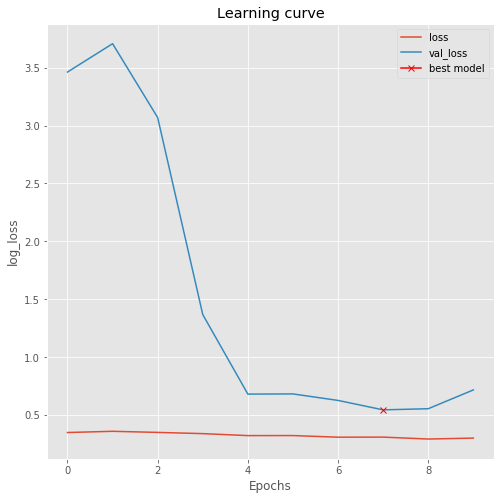

In [534]:
plt.figure(figsize=(8, 8))
plt.title("Learning curve")
plt.plot(results.history["loss"], label="loss")
plt.plot(results.history["val_loss"], label="val_loss")
plt.plot( np.argmin(results.history["val_loss"]), np.min(results.history["val_loss"]), marker="x", color="r", label="best model")
plt.xlabel("Epochs")
plt.ylabel("log_loss")
plt.legend();

In [535]:
model.load_weights('model-weights.h5')

In [536]:
model.evaluate(X_valid, y_valid, verbose=1)

4/4 [==============================] - 0s 18ms/step


[0.5461363792419434, 0.7865447998046875]

In [537]:
preds_train = model.predict(X_train, verbose=1)
preds_val = model.predict(X_valid, verbose=1)

4/4 [==============================] - 0s 17ms/step


In [538]:
preds_train_t = (preds_train > 0.5).astype(np.uint8)

In [539]:
preds_val_t = (preds_val > 0.5).astype(np.uint8)

In [540]:
def plot_sample(X, y, preds, binary_preds, ix=None):
    if ix is None:
        ix = random.randint(0, len(X))

    has_mask = y[ix].max() > 0

    fig, ax = plt.subplots(1, 4, figsize=(20, 10))
    ax[0].imshow(X[ix, ..., 0], cmap='coolwarm')
    if has_mask:
        ax[0].contour(y[ix].squeeze(), colors='k', levels=[0.5])
    ax[0].set_title('patient image')

    ax[1].imshow(y[ix].squeeze())
    ax[1].set_title('ground truth')

    ax[2].imshow(binary_preds[ix].squeeze(), vmin=0, vmax=1)
    if has_mask:
        ax[2].contour(y[ix].squeeze(), colors='k', levels=[0.5])
    ax[2].set_title('burn predicted binary');
    
    ax[3].imshow(preds[ix].squeeze(), vmin=0, vmax=1)
    if has_mask:
        ax[3].contour(y[ix].squeeze(), colors='k', levels=[0.5])
    ax[3].set_title('burn predicted')
    
    

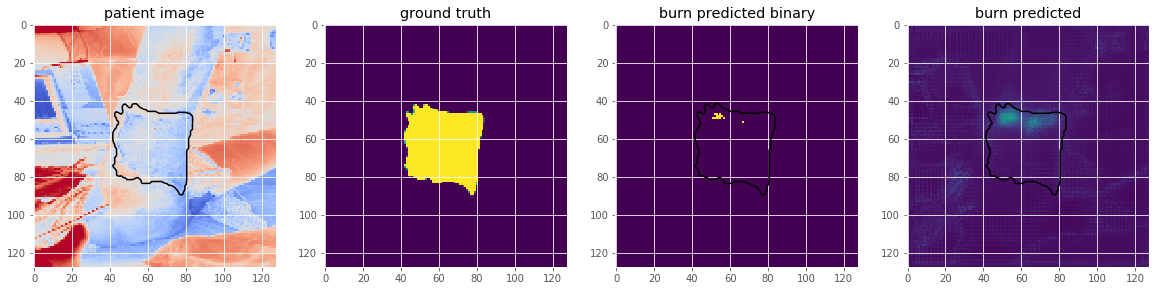

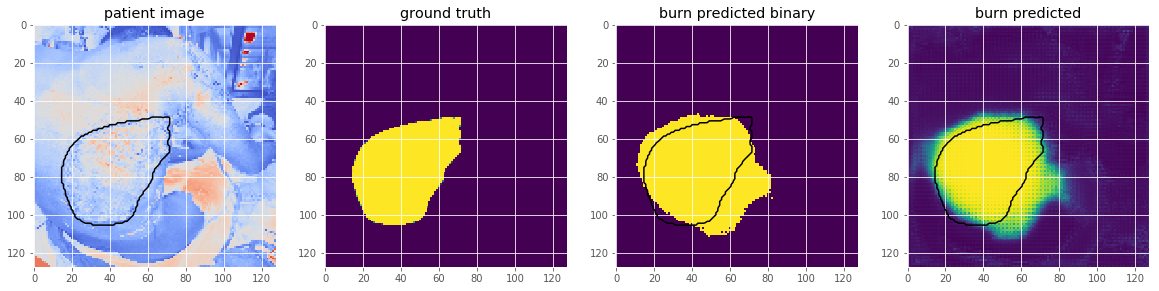

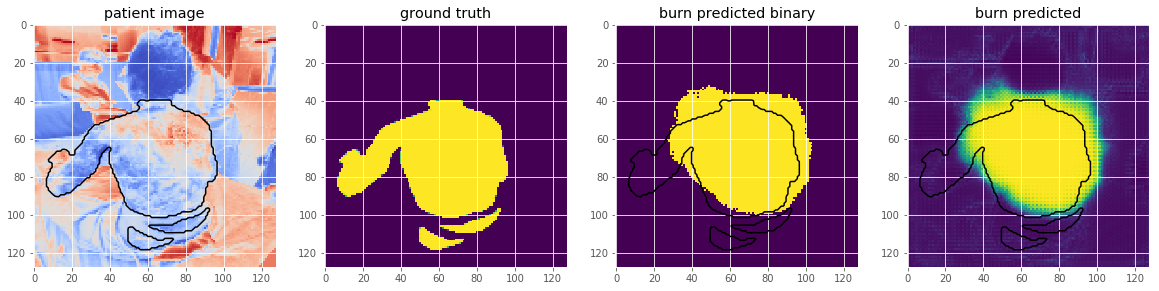

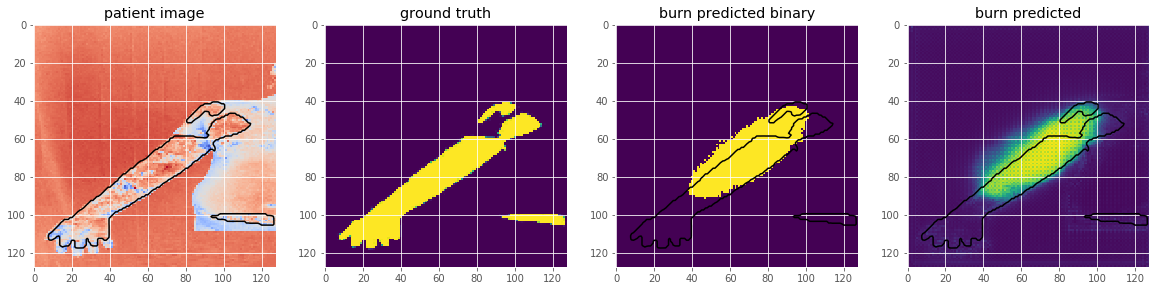

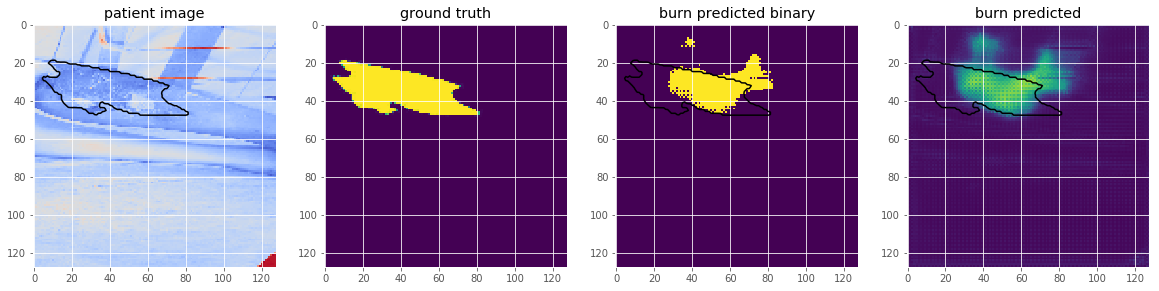

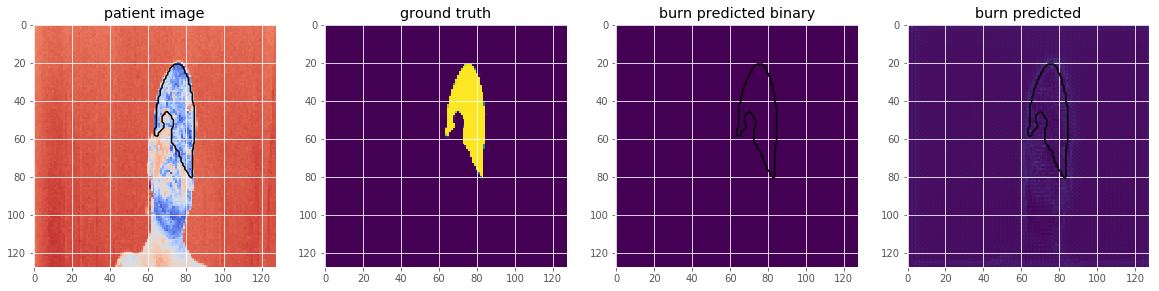

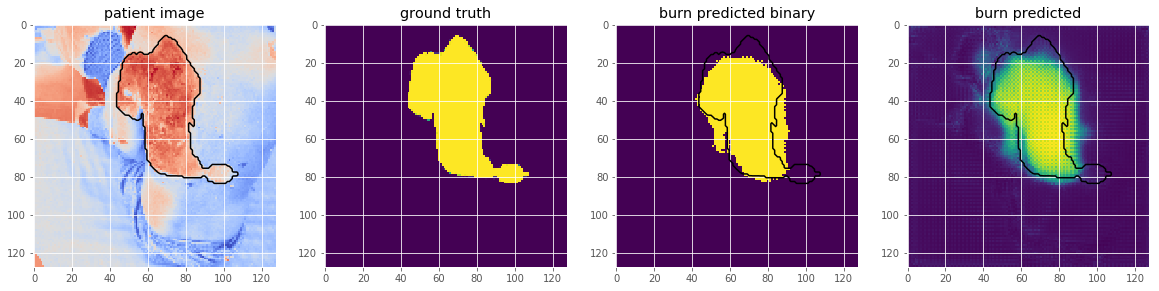

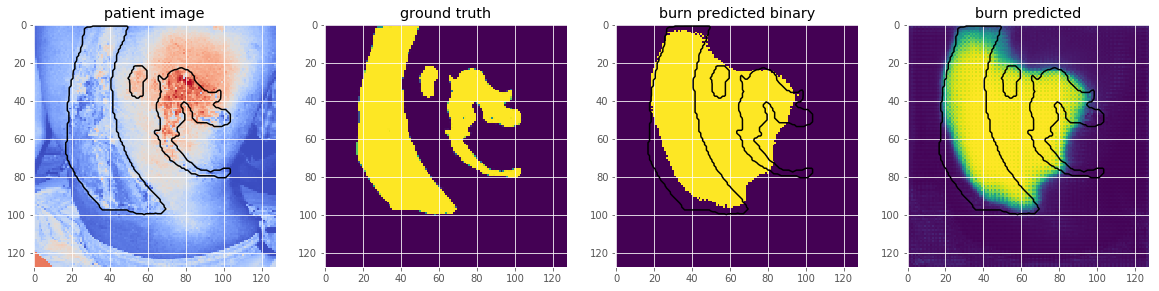

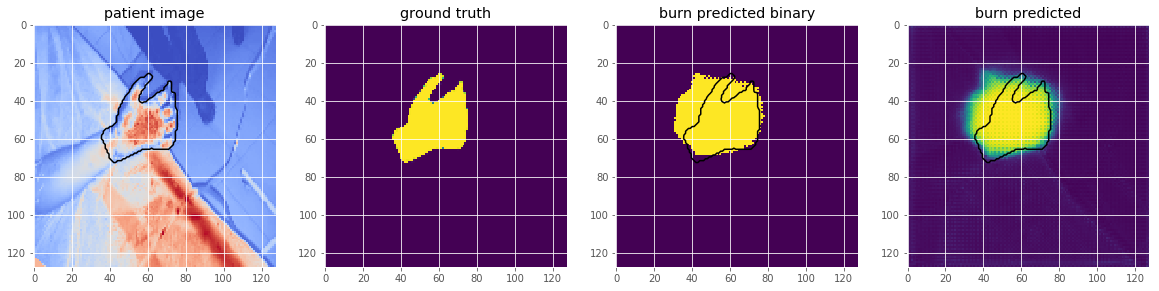

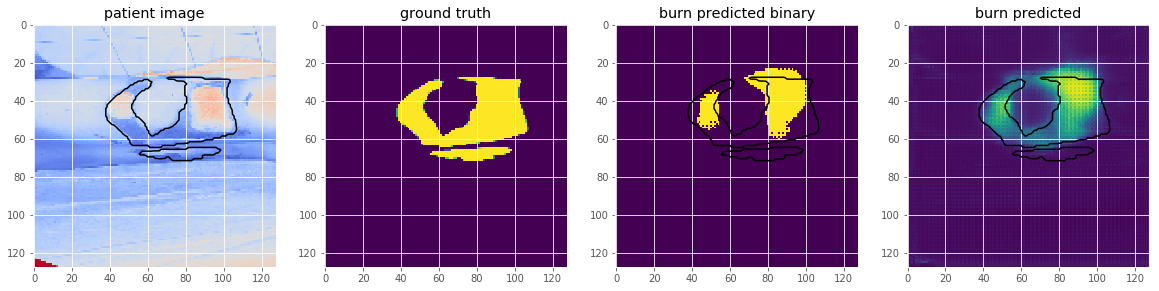

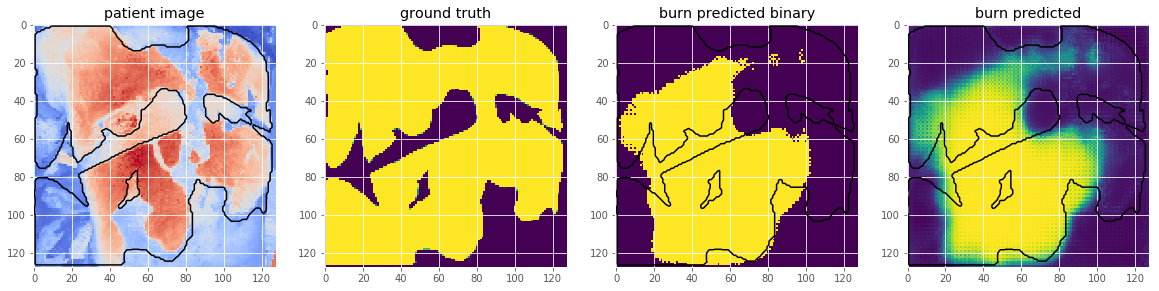

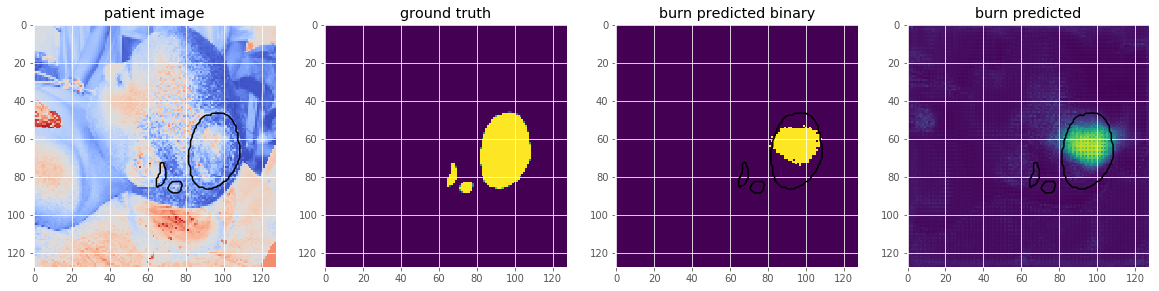

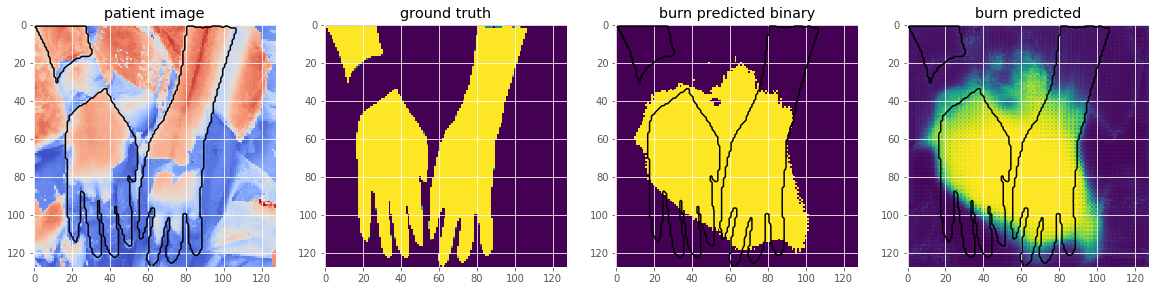

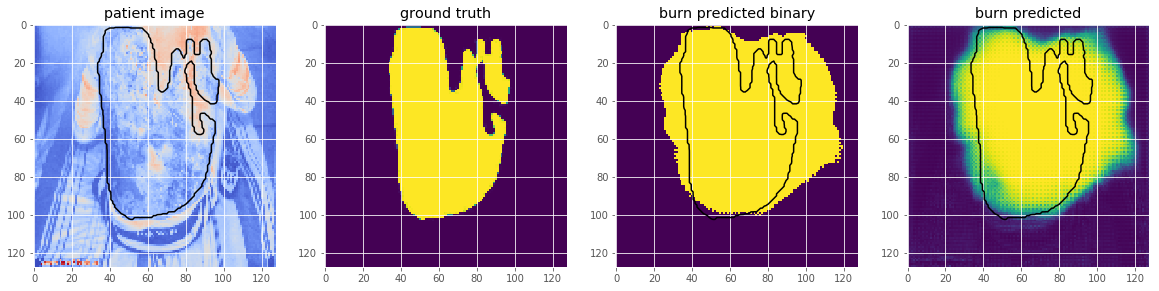

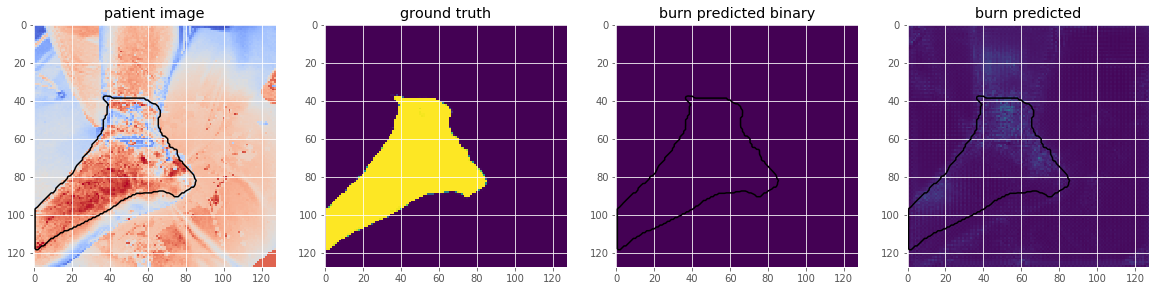

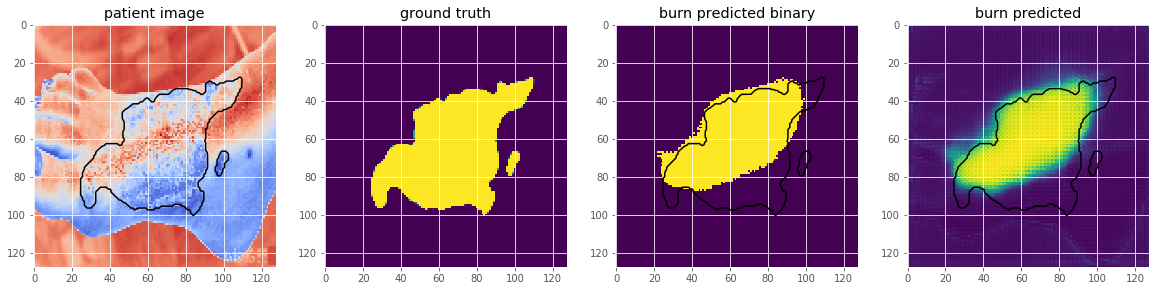

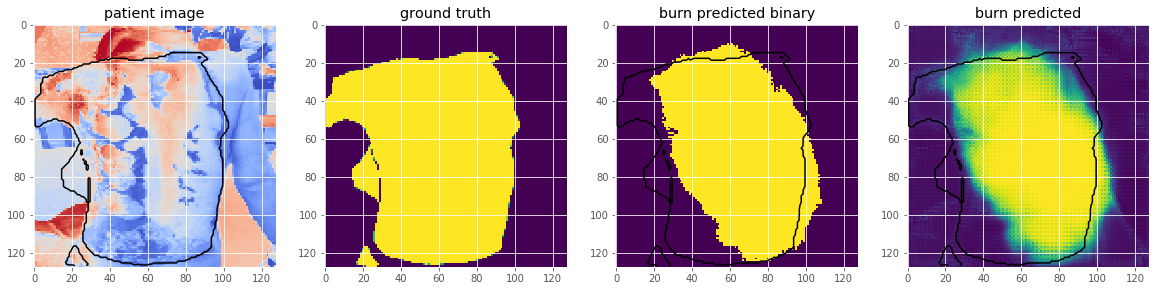

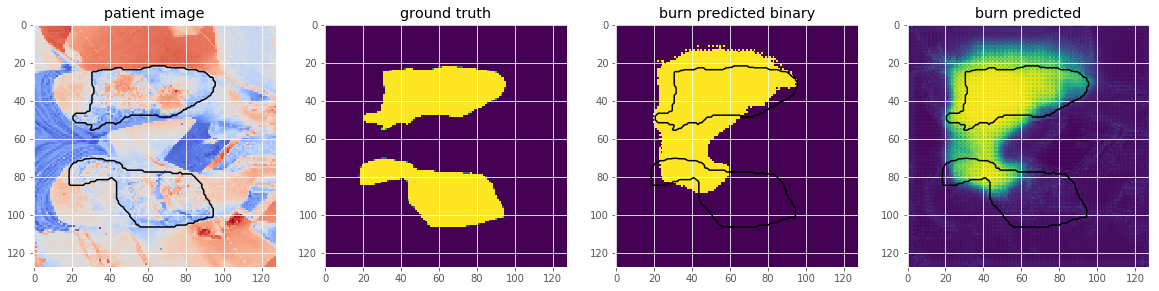

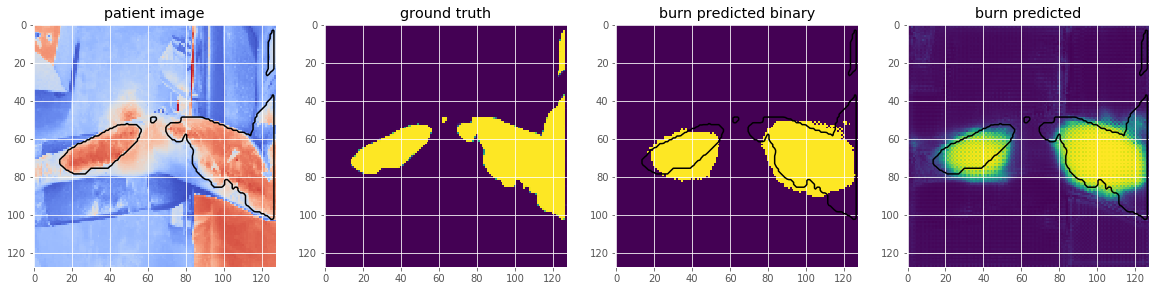

In [567]:
for u in range(0,19):
    plot_sample(X_train, y_train, preds_train, preds_train_t, ix=u)

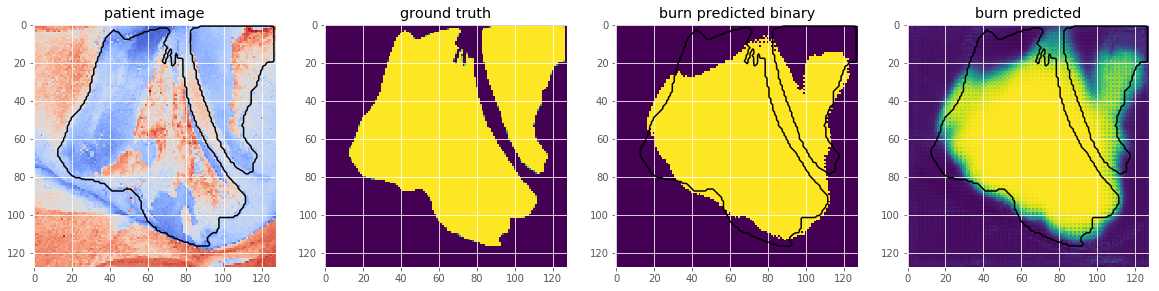

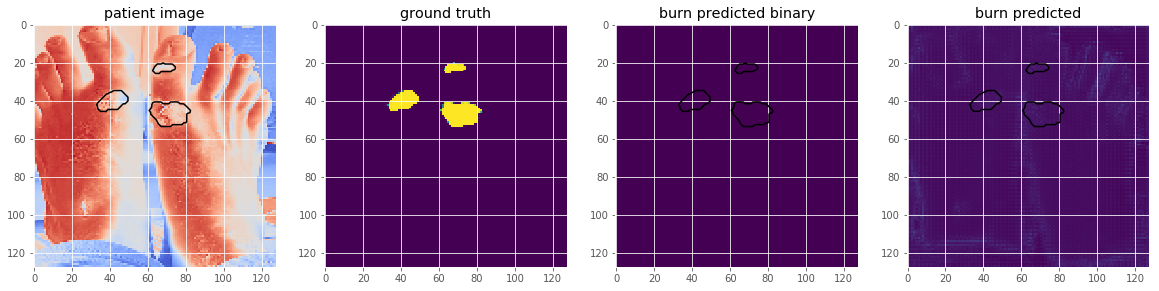

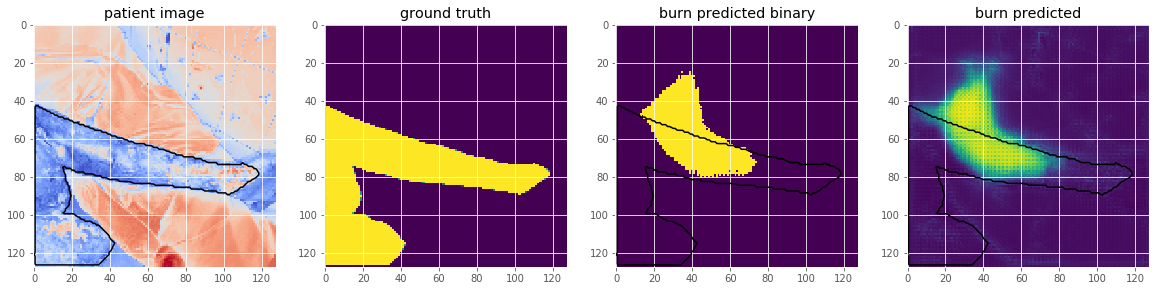

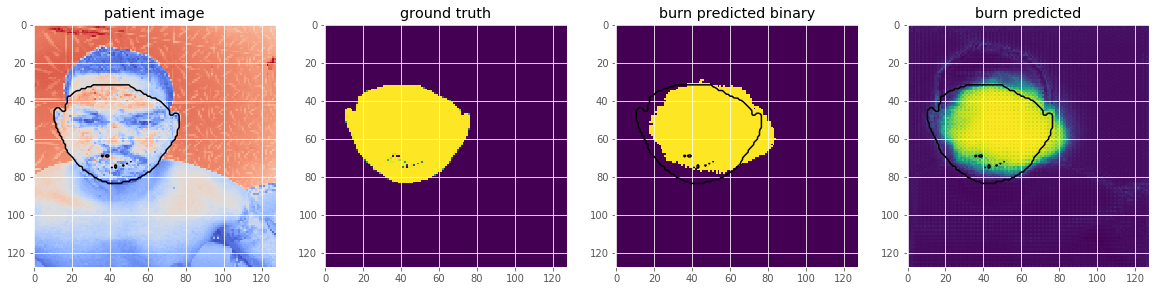

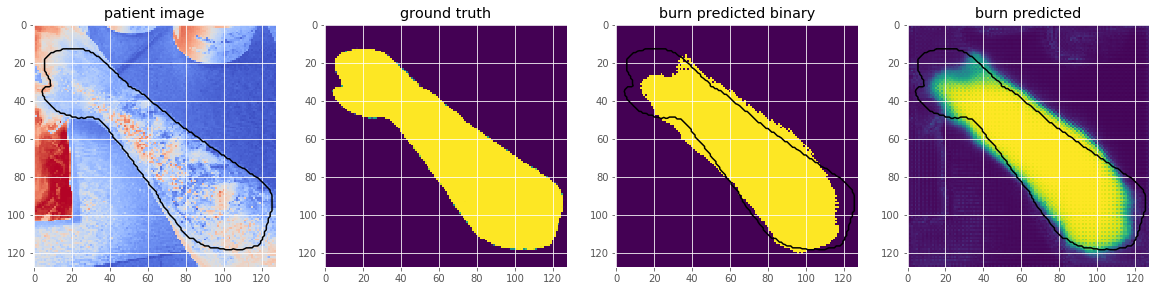

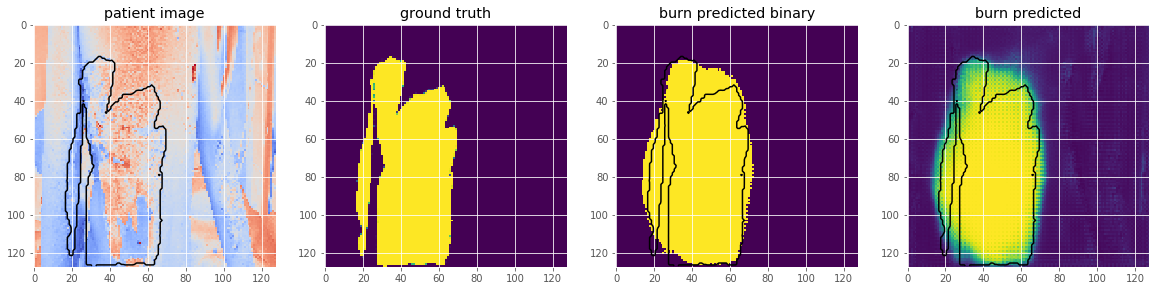

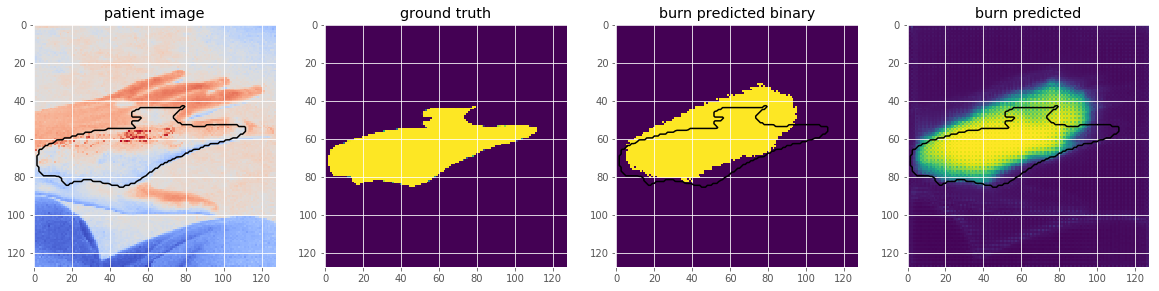

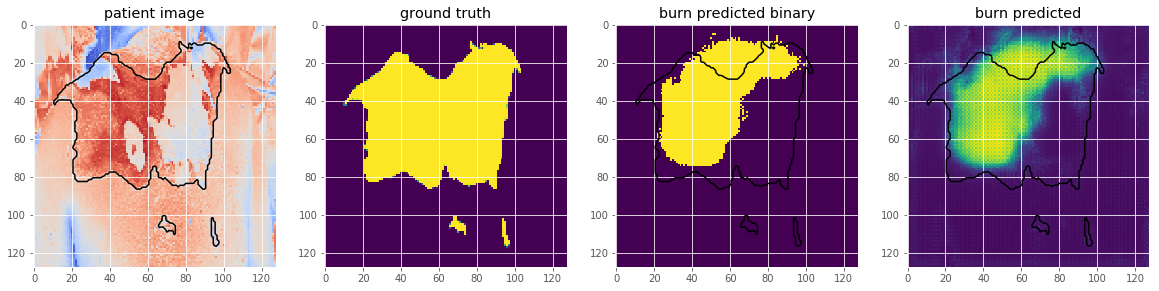

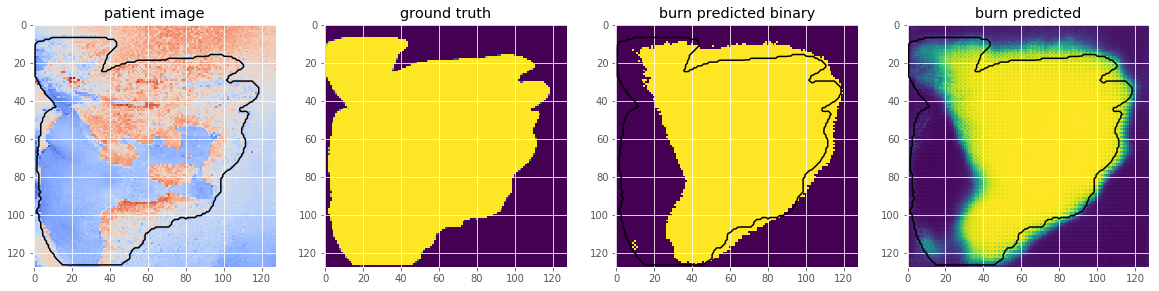

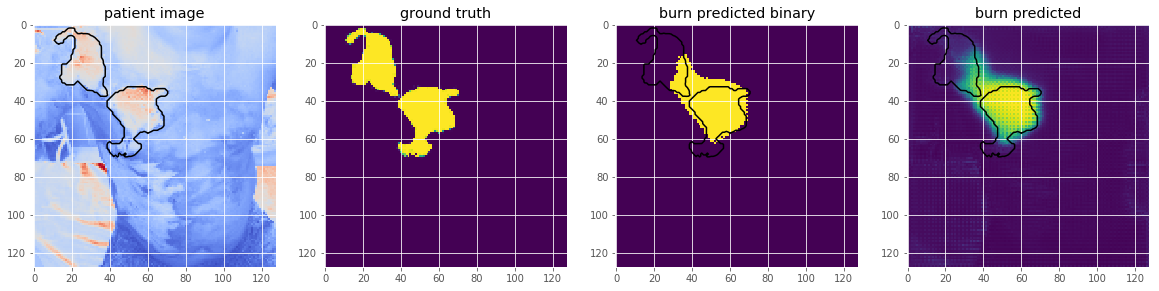

In [570]:
for u in range(19,29):
    plot_sample(X_train, y_train, preds_train, preds_train_t, ix=u)